# Extended Kalman Filter Project

## Code architecture
The code was implemented as required in the following files:
- main.cpp: Main routine with WebSocket connection to simulator. Modifications were done to write all relevant data to log files for analysis in a Jupyter notebook
- measurement_package.h: Measurement definition as received by the WebSocket
- ukf.cpp/ukf.h: Contains the ukf class for implementation of the unscented Kalman filter.
- tools.h/tools.cpp: Helper functions to convert polar <-> cartesian coordinates and to calculate RMSE

## Implementation
The implementation of the Unscented Kalman filter was straight forward, since most of the codebase was already supplied by the udacity lectures. The sigma point generation and prediction was taken over with some modifications for a common coding scheme. The update function was split into the UpdateLaser() and UpdateRadar() part with the common functionality consolidated into the UpdateState() method. The UpdateRadar() was mostly supplied by the udacity lectures, while the UpdateLaser() function had to be modified to work with the laser measurements.

## Analysis
To analyze the performance of the Unscented Kalman filter the code writes datalog.dat files of all relevant data in CSV format:
- time: current timestamp of measurement
- sensortype: LASER or RADAR sensor measurement
- gt_x,gt_y,gt_vx,gt_vy: ground truth of position and velocity
- est_x,est_y,est_vx,est_vy: estimate for position and velocity
- rmse_x,rmse_y,rmse_vx,rmse_vy: RMSE between ground truth and velocty
- nis: NIS value to judge performance

## Optimization
In order to meet the target values of RMSE the parameters "std_a" and "std_yawdd" where adjusted as suggested. The final values of "std_a" : 0.2, "std_yawdd" : 0.2 provide good results and the NIS is also within an acceptable range.

In [11]:
import matplotlib.pyplot as plt
import csv
import json
from pprint import pprint
import os

%matplotlib inline

MAX_RMSE_POS_X = 0.09
MAX_RMSE_POS_Y = 0.10
MAX_RMSE_VEL_X = 0.40
MAX_RMSE_VEL_Y = 0.30
MAX_NIS = 8

def create_plots(dataset):
    print('CONFIGURATION:')
    with open('./data/' + dataset + '.json') as json_data:
        d = json.load(json_data)
        json_data.close()
        pprint(d)
    
    datafiles = ['./data/' + dataset + '_dataset' + str(i) + '.dat' for i in [1,2]]
    datafiles = [d for d in datafiles if os.path.exists(d)]

    for df in datafiles:
        print('DATAFILE: ' + df)
        with open(df, 'r') as csvfile:
            csvreader = csv.reader(csvfile, delimiter=',', quotechar='|')

            header_row = next(csvreader)

            data = dict.fromkeys(header_row)
            for key in data:
                data[key] = []

            for row in csvreader:
                for i,item in enumerate(row):
                    try:
                        data[header_row[i]].append(float(item))
                    except:
                        data[header_row[i]].append(item)

        time_min = data['time'][0]
        time_max = data['time'][-1]
        time_bounds = [time_min, time_max]

        plt.figure(figsize=(20,15))

        plt.subplot(3,2,1)
        plt.plot(data['gt_x'], data['gt_y'], 'b-', data['est_x'], data['est_y'], 'r-')
        plt.xlabel('x pos')
        plt.ylabel('y pos')
        plt.legend(['ground truth', 'estimate'])

        plt.subplot(3,2,2)
        plt.plot(data['gt_vx'], data['gt_vy'], 'b-', data['est_vx'], data['est_vy'], 'r-')
        plt.xlabel('x vel')
        plt.ylabel('y vel')
        plt.legend(['ground truth', 'estimate'])

        plt.subplot(3,2,3)
        plt.plot(data['time'], data['rmse_x'], 'b-', data['time'], data['rmse_y'], 'r-',)
        plt.plot(time_bounds, [MAX_RMSE_POS_X, MAX_RMSE_POS_X], 'b--')
        plt.plot(time_bounds, [MAX_RMSE_POS_Y, MAX_RMSE_POS_Y], 'r--')
        plt.ylabel('rmse pos')
        plt.ylim([0,0.25])
        plt.legend(['x', 'y', 'limit'])

        plt.subplot(3,2,4)
        plt.plot(data['time'], data['rmse_vx'], 'b-', data['time'], data['rmse_vy'], 'r-',)
        plt.plot(time_bounds, [MAX_RMSE_VEL_X, MAX_RMSE_VEL_X], 'b--')
        plt.plot(time_bounds, [MAX_RMSE_VEL_Y, MAX_RMSE_VEL_Y], 'r--')
        plt.ylabel('rms vel')
        plt.ylim([0,2])
        plt.legend(['x', 'y', 'limit'])
        
        radar_nis = [d for i,d in enumerate(data['nis']) if data['sensortype'][i] == 'RADAR']
        radar_time = [d for i,d in enumerate(data['time']) if data['sensortype'][i] == 'RADAR']
        plt.subplot(3,2,5)
        plt.plot(radar_time, radar_nis, 'b')
        plt.plot(time_bounds, [MAX_NIS, MAX_NIS], 'g--')
        plt.ylabel('NIS radar')
        plt.ylim([0,15])
        
        laser_nis = [d for i,d in enumerate(data['nis']) if data['sensortype'][i] == 'LASER']
        laser_time = [d for i,d in enumerate(data['time']) if data['sensortype'][i] == 'LASER']
        plt.subplot(3,2,6)
        plt.plot(laser_time, laser_nis, 'b')     
        plt.plot(time_bounds, [MAX_NIS, MAX_NIS], 'g--')
        plt.ylabel('NIS laser')
        plt.ylim([0,15])

        plt.show()

# Default settings
To start the default settings from the provided codebase are used. These already give quite a satisfactory result with the RMSE of position / velocity meeting the target values of 0.11 / 0.52 (dashed lines) with dataset1 of the simulator. For dataset2 the RMSE vel_x is not within the acceptance range, but the extrapolation shows it would be within the bound with a longer simulation run.

CONFIGURATION:
{'UKF': {'laser_enabled': 1,
         'n_aug': 7,
         'n_x': 5,
         'radar_enabled': 1,
         'std_a': 0.2,
         'std_laspx': 0.15,
         'std_laspy': 0.15,
         'std_radphi': 0.03,
         'std_radr': 0.3,
         'std_radrd': 0.3,
         'std_yawdd': 0.2}}
DATAFILE: ./data/config01_default_dataset1.dat


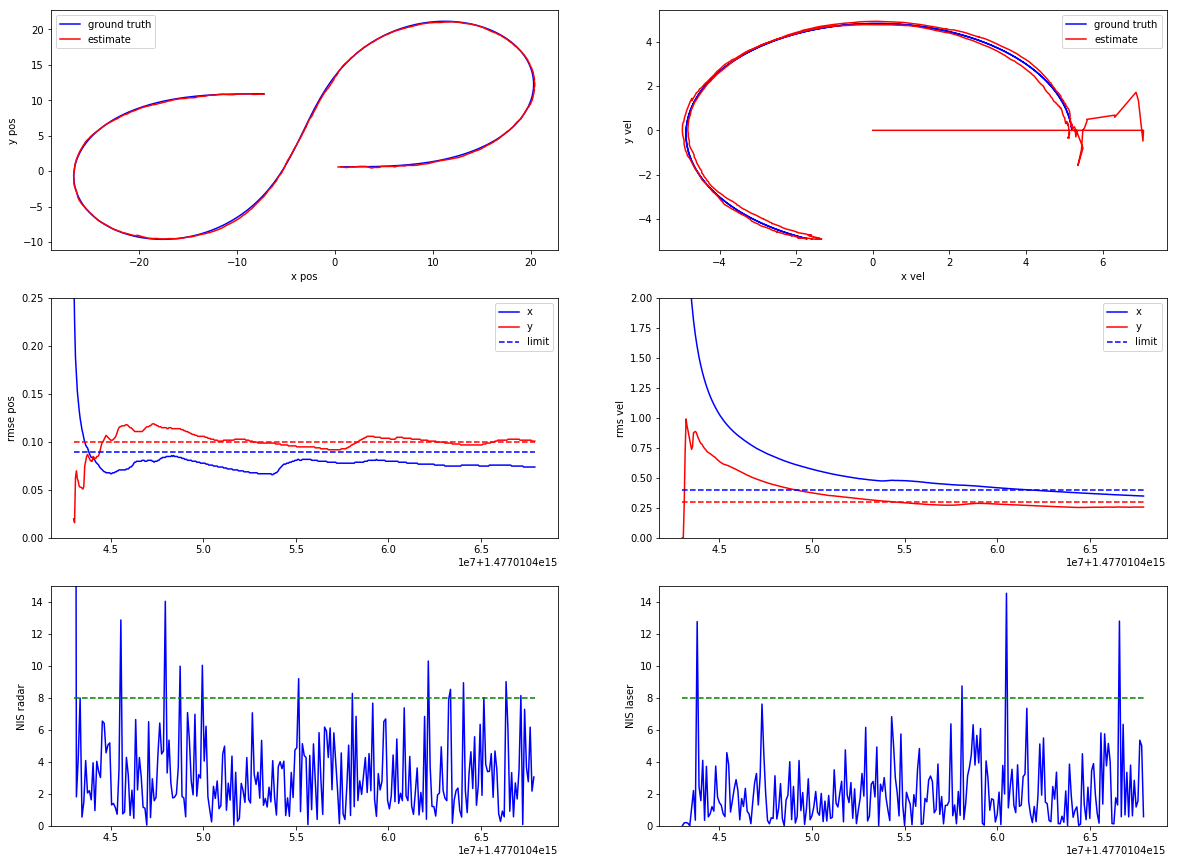

DATAFILE: ./data/config01_default_dataset2.dat


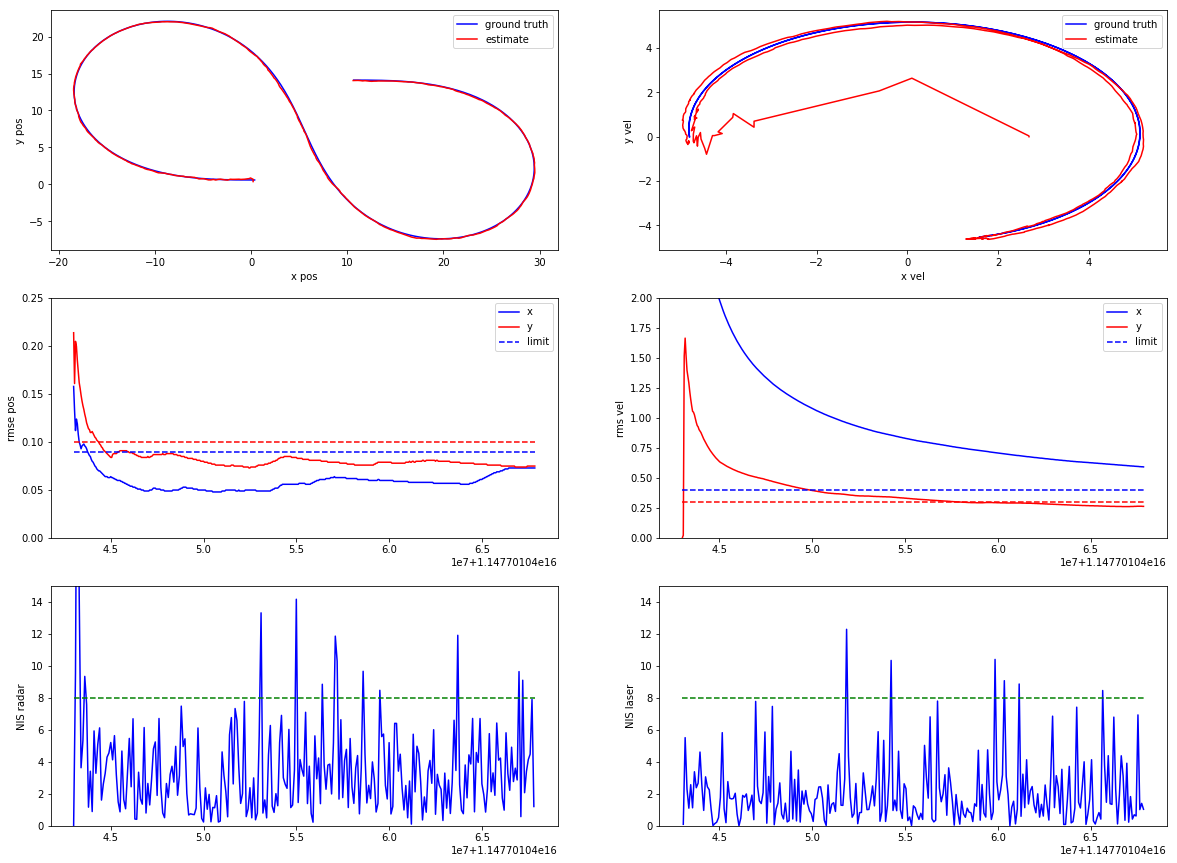

In [12]:
dataset = 'config01_default'

create_plots(dataset)

# Radar / Laser measurements
To analyze the influence of Laser and Radar measurements one was turned off and the parameters for the other were tune (more / less measurement noise)

## Laser only
With laser only the overall accuracy drops and the measurement noise does not have much influence. The overall performance increase with 

CONFIGURATION:
{'UKF': {'laser_enabled': 1,
         'n_aug': 7,
         'n_x': 5,
         'radar_enabled': 0,
         'std_a': 0.2,
         'std_laspx': 0.15,
         'std_laspy': 0.15,
         'std_radphi': 0.03,
         'std_radr': 0.3,
         'std_radrd': 0.3,
         'std_yawdd': 0.2}}
DATAFILE: ./data/config02_laseronly_dataset1.dat


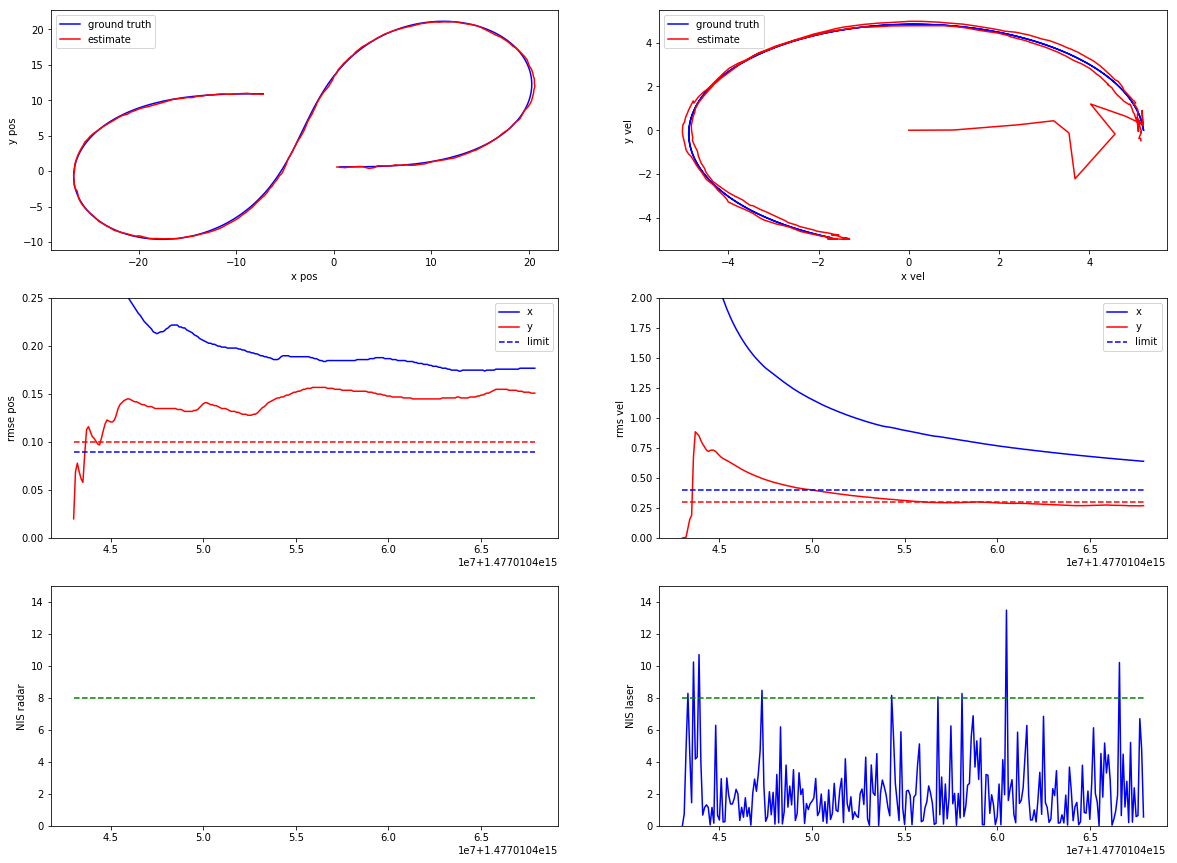

In [14]:
datasets = ['config02_laseronly']

for d in datasets:
    create_plots(d)

# Radar only
With Radar measurements only the position data is quite off, as can be expected since the Radar provides more accurate velocity information. The overall performance is slightly better with less measurement noise.

CONFIGURATION:
{'UKF': {'laser_enabled': 0,
         'n_aug': 7,
         'n_x': 5,
         'radar_enabled': 1,
         'std_a': 0.2,
         'std_laspx': 0.15,
         'std_laspy': 0.15,
         'std_radphi': 0.03,
         'std_radr': 0.3,
         'std_radrd': 0.3,
         'std_yawdd': 0.2}}
DATAFILE: ./data/config03_radaronly_dataset1.dat


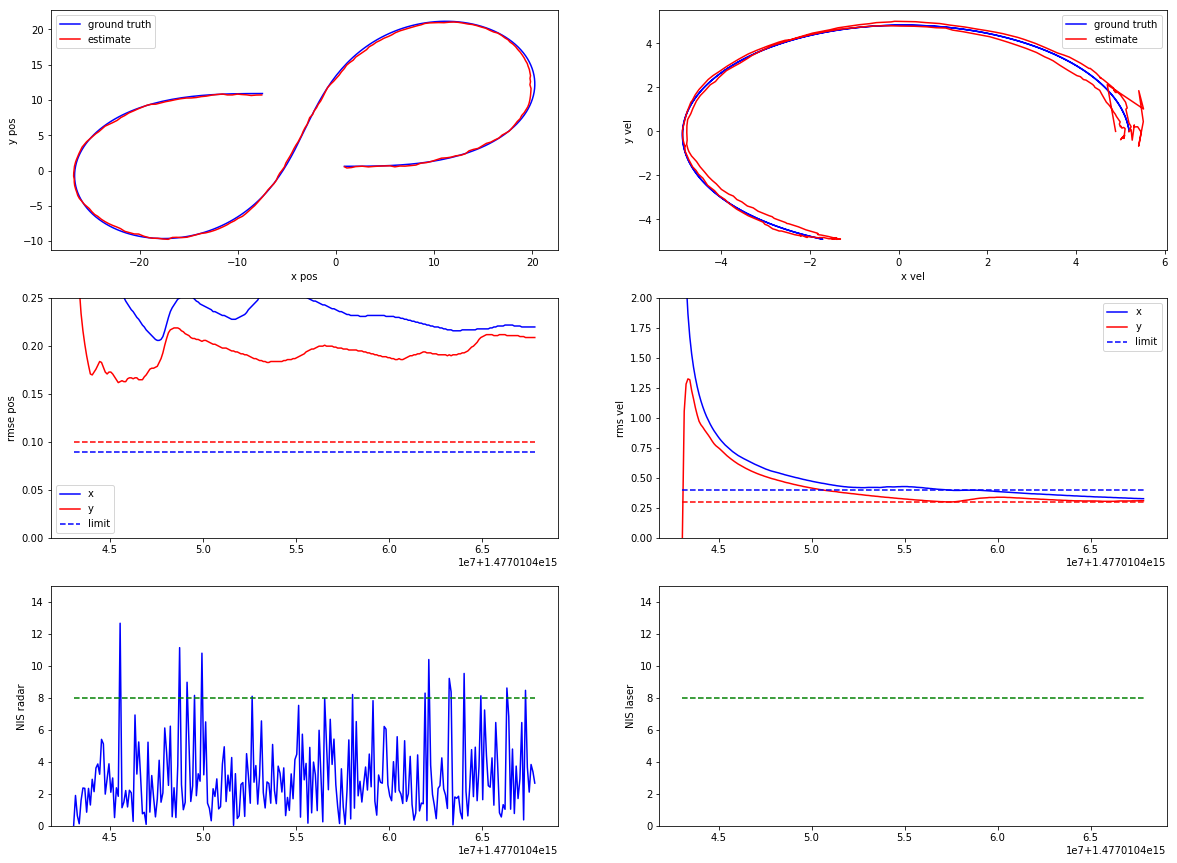

In [15]:
datasets = ['config03_radaronly']

for d in datasets:
    create_plots(d)

# Discussion
The Unscented Kalman filter performs very well in fusing the laser and radar measurements. The radar measurements seem to have a larger impact on the accuracy of the filter output. Compared to the Unscented Kalman filter better RMSE was achieved with the same datasets from the simulator (https://github.com/rgansch/CarND-Extended-Kalman-Filter-Project/blob/master/Writeup.ipynb)

## Possible improvements
The process noise parameters can be further fine tuned to get slightly better performance (educated guess: ~20% better RMSE possible).